In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
    import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch



In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & val loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.0)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
!pip install torch-summary
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torchmetrics

In [ ]:
from torchsummary import summary

In [ ]:
import opendatasets as od

# Download the dataset
od.download('https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification?select=dataset', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aqsachappalwala123
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


100%|██████████| 736M/736M [00:14<00:00, 54.1MB/s]


In [ ]:
PATH = '/content/eye-diseases-classification/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
1465,/content/eye-diseases-classification/dataset/g...,1
1700,/content/eye-diseases-classification/dataset/g...,1
4121,/content/eye-diseases-classification/dataset/n...,3
2284,/content/eye-diseases-classification/dataset/c...,2
1346,/content/eye-diseases-classification/dataset/g...,1


<ipython-input-9-949d57b1b1b9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

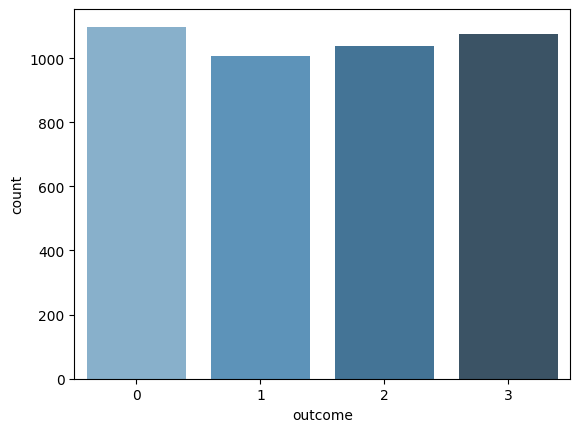

In [ ]:
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')

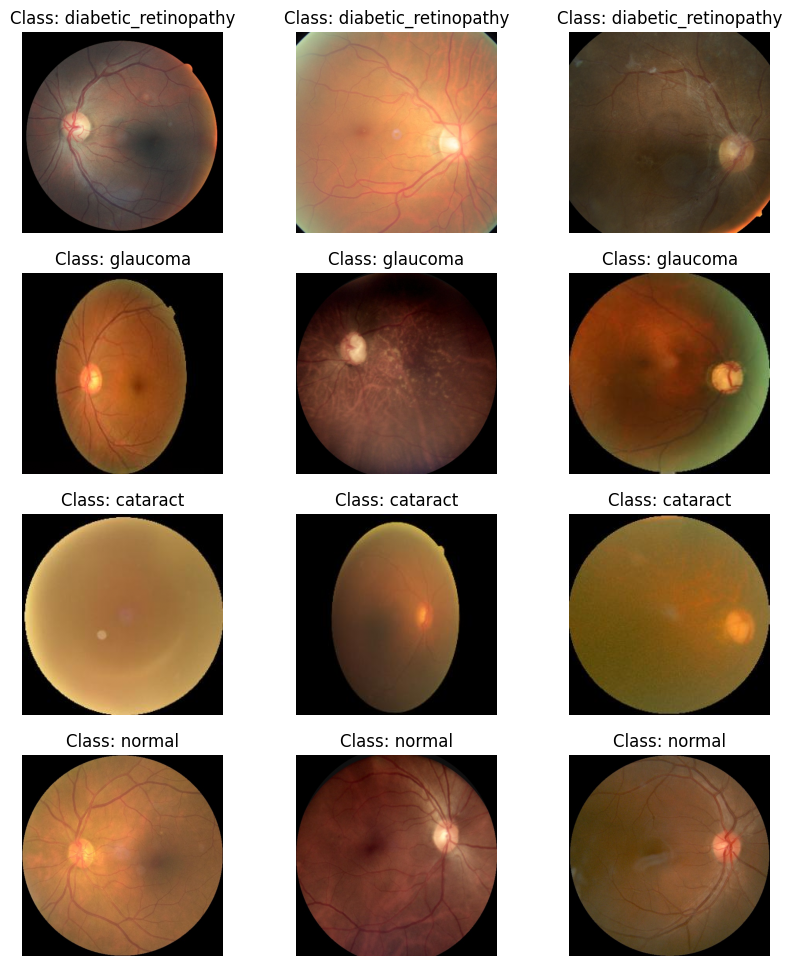

In [ ]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min())/img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test sets (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Splitting test set into validation and test sets (50-50 split of the remaining 20%)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Printing the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (3373, 2)
Validation set shape: (422, 2)
Test set shape: (422, 2)


In [ ]:
NUM_CLASSES = 4
# Define the batch size
BATCH_SIZE = 32

train_dataset = EyeDataset(train_df, NUM_CLASSES, train_transform)
test_dataset=EyeDataset(test_df, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(valid_df, NUM_CLASSES, val_transform)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


In [ ]:
os.listdir()

['.config', 'eye-diseases-classification', 'sample_data']

do image augmentation and implement fine tuning for different models and see performane.You can create models and make a table and write if any model has enhanced the performance.

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(1024 * 7 * 7, 256),  # Adjust the input size based on the output size of the last convolution layer
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, num_classes]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flattened before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
num_classes = 4  # Number of classes (e.g., normal, cataract, diabetic retino, glaucoma)
model = MyCNN(num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=50176, out_features

4 Define Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
print(os.listdir("./eye-diseases-classification"))

['dataset']


In [ ]:
!pip install tqdm
from tqdm import tqdm

In [ ]:
# Save the best model checkpoint to the specified file path
best_model_path = 'best_model.pth'
torch.save(model.state_dict(), best_model_path)

In [ ]:
# Load the best model checkpoint
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
# The number of training epochs.
n_epochs = 25
# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


[Epoch: 001/025] Train: loss=1.31228, acc=0.34915 | Valid: loss=1.16691, acc=0.31920


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


[Epoch: 002/025] Train: loss=1.05098, acc=0.47530 | Valid: loss=0.91633, acc=0.61384


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


[Epoch: 003/025] Train: loss=0.88804, acc=0.56377 | Valid: loss=0.89796, acc=0.61756


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


[Epoch: 004/025] Train: loss=0.84018, acc=0.56994 | Valid: loss=0.79029, acc=0.67857


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


[Epoch: 005/025] Train: loss=0.82114, acc=0.59618 | Valid: loss=0.80238, acc=0.64286


100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


[Epoch: 006/025] Train: loss=0.80504, acc=0.61445 | Valid: loss=0.71913, acc=0.69420


100%|██████████| 14/14 [00:14<00:00,  1.03s/it]


[Epoch: 007/025] Train: loss=0.75236, acc=0.65128 | Valid: loss=0.69053, acc=0.70536


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


[Epoch: 008/025] Train: loss=0.73361, acc=0.66278 | Valid: loss=0.67056, acc=0.73586


100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


[Epoch: 009/025] Train: loss=0.66680, acc=0.71319 | Valid: loss=0.58990, acc=0.76414


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


[Epoch: 010/025] Train: loss=0.61029, acc=0.73900 | Valid: loss=0.59506, acc=0.77604


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


[Epoch: 011/025] Train: loss=0.60483, acc=0.74342 | Valid: loss=0.51649, acc=0.80729


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


[Epoch: 012/025] Train: loss=0.55763, acc=0.77066 | Valid: loss=0.54804, acc=0.81399


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


[Epoch: 013/025] Train: loss=0.49998, acc=0.79649 | Valid: loss=0.42986, acc=0.87277


100%|██████████| 14/14 [00:08<00:00,  1.68it/s]


[Epoch: 014/025] Train: loss=0.50576, acc=0.79381 | Valid: loss=0.45935, acc=0.82515


100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


[Epoch: 015/025] Train: loss=0.48260, acc=0.80545 | Valid: loss=0.41767, acc=0.85417


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


[Epoch: 016/025] Train: loss=0.46578, acc=0.81606 | Valid: loss=0.44200, acc=0.84970


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


[Epoch: 017/025] Train: loss=0.45533, acc=0.81842 | Valid: loss=0.45484, acc=0.84077


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


[Epoch: 018/025] Train: loss=0.43859, acc=0.81753 | Valid: loss=0.44582, acc=0.83631


100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


[Epoch: 019/025] Train: loss=0.43358, acc=0.82697 | Valid: loss=0.45877, acc=0.78348


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


[Epoch: 020/025] Train: loss=0.42362, acc=0.82432 | Valid: loss=0.45501, acc=0.84077


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


[Epoch: 021/025] Train: loss=0.41803, acc=0.83184 | Valid: loss=0.42056, acc=0.86756


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


[Epoch: 022/025] Train: loss=0.40006, acc=0.84581 | Valid: loss=0.40330, acc=0.86533


100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


[Epoch: 023/025] Train: loss=0.39257, acc=0.84541 | Valid: loss=0.45184, acc=0.83408


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


[Epoch: 024/025] Train: loss=0.40083, acc=0.83906 | Valid: loss=0.39821, acc=0.87723


100%|██████████| 14/14 [00:09<00:00,  1.52it/s]

[Epoch: 025/025] Train: loss=0.39543, acc=0.83962 | Valid: loss=0.42911, acc=0.86086


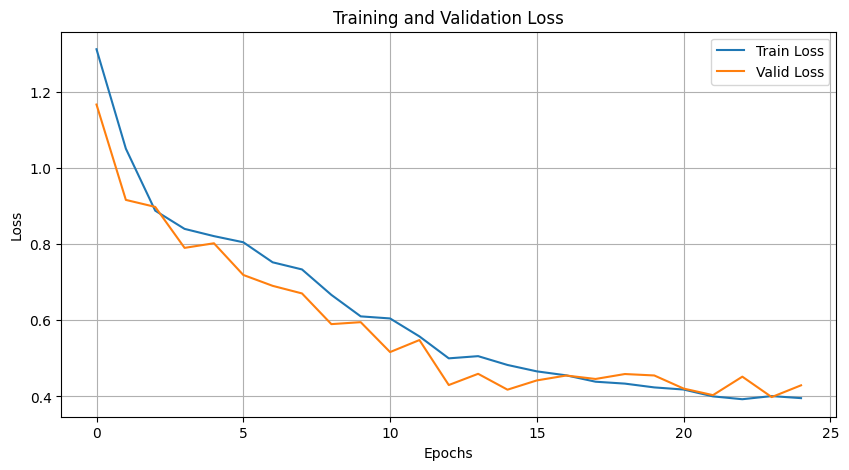

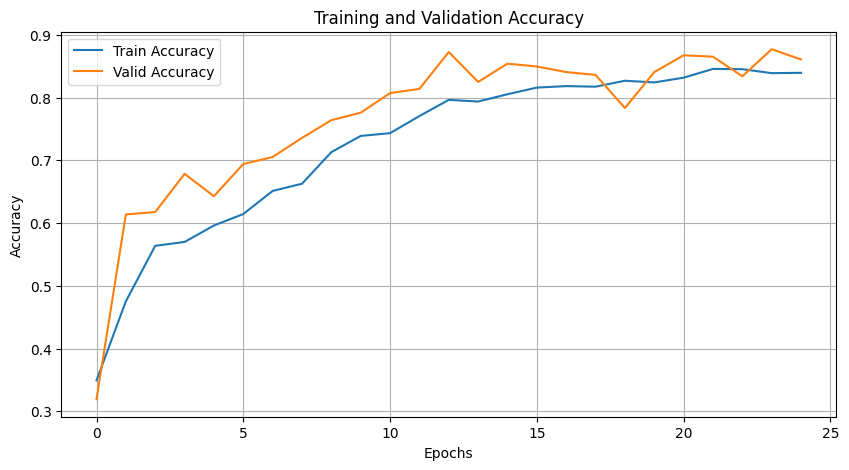

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

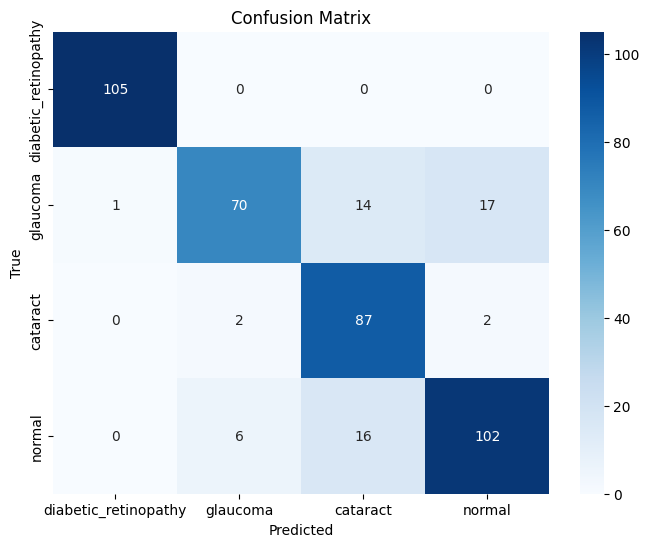

Confusion Matrix:
 [[105   0   0   0]
 [  1  70  14  17]
 [  0   2  87   2]
 [  0   6  16 102]]
Precision: 0.8686
Recall: 0.8662
F1 Score: 0.8606


In [ ]:
import seaborn as sns
# Make sure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Iterate over the validation set
for batch in val_loader:
    imgs, labels = batch
    imgs = imgs.to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(imgs)

    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=1)

    # Get predictions (class with highest probability)
    preds = torch.argmax(probs, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Assign the lists to y_true and y_pred
y_true = all_labels
y_pred = all_preds

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")


In [ ]:
# Assuming you have a trained ResNet model instance called `model`
torch.save(model.state_dict(), 'resnet_model.pth')

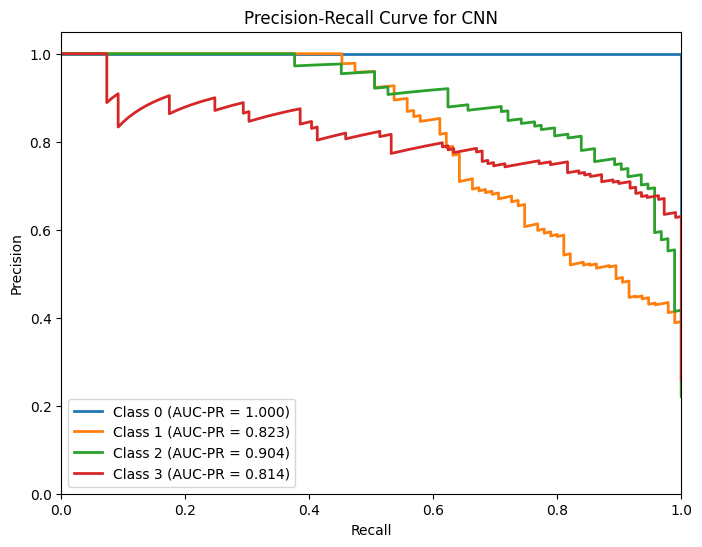

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained CNN model
model = MyCNN(num_classes)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Assuming you have test_loader for the test dataset
y_true = []
y_score = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Collect true labels and model scores/probabilities
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.softmax(dim=1).cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_score = np.array(y_score)

# Compute precision-recall curve and AUC-PR for each class
n_classes = y_score.shape[1]
precision, recall, thresholds = dict(), dict(), dict()
auc_pr = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_score[:, i])
    auc_pr.append(average_precision_score(y_true == i, y_score[:, i]))

# Plot the PR curve for each class
plt.figure(figsize=(8, 6))
lines = []
labels = []
for i in range(n_classes):
    line, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(line)
    labels.append(f'Class {i} (AUC-PR = {auc_pr[i]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for CNN')
plt.legend(lines, labels, loc='best')
plt.show()

##ResNet Model

In [ ]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained = True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()


    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x


In [ ]:
class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)

        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))

In [ ]:
trainer = Trainer(train_loader, val_loader, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.6MB/s]


In [ ]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [ ]:
trainer.train(epochs = 25)

100%|██████████| 106/106 [01:03<00:00,  1.67it/s]

  4%|▍         | 1/25 [01:12<28:54, 72.26s/it]

[Epoch: 1] Train: [loss: 0.601 acc: 0.765] Val: [loss: 0.518 acc:0.807]



100%|██████████| 106/106 [01:03<00:00,  1.67it/s]

  8%|▊         | 2/25 [02:23<27:33, 71.90s/it]

[Epoch: 2] Train: [loss: 0.315 acc: 0.887] Val: [loss: 0.340 acc:0.856]



100%|██████████| 106/106 [01:08<00:00,  1.55it/s]

 12%|█▏        | 3/25 [03:40<27:05, 73.90s/it]

[Epoch: 3] Train: [loss: 0.236 acc: 0.913] Val: [loss: 0.383 acc:0.858]



100%|██████████| 106/106 [01:02<00:00,  1.69it/s]

 16%|█▌        | 4/25 [04:51<25:33, 73.04s/it]

[Epoch: 4] Train: [loss: 0.207 acc: 0.923] Val: [loss: 0.326 acc:0.876]



100%|██████████| 106/106 [01:03<00:00,  1.66it/s]

 20%|██        | 5/25 [06:03<24:13, 72.65s/it]

[Epoch: 5] Train: [loss: 0.174 acc: 0.936] Val: [loss: 0.432 acc:0.851]



100%|██████████| 106/106 [01:02<00:00,  1.70it/s]

 24%|██▍       | 6/25 [07:15<22:53, 72.28s/it]

[Epoch: 6] Train: [loss: 0.159 acc: 0.943] Val: [loss: 0.305 acc:0.903]



100%|██████████| 106/106 [01:03<00:00,  1.67it/s]

 28%|██▊       | 7/25 [08:27<21:40, 72.23s/it]

[Epoch: 7] Train: [loss: 0.131 acc: 0.946] Val: [loss: 0.335 acc:0.881]



100%|██████████| 106/106 [01:03<00:00,  1.68it/s]

 32%|███▏      | 8/25 [09:40<20:29, 72.32s/it]

[Epoch: 8] Train: [loss: 0.126 acc: 0.951] Val: [loss: 0.501 acc:0.844]



100%|██████████| 106/106 [01:04<00:00,  1.66it/s]

 36%|███▌      | 9/25 [10:53<19:20, 72.56s/it]

[Epoch: 9] Train: [loss: 0.097 acc: 0.964] Val: [loss: 0.422 acc:0.869]



100%|██████████| 106/106 [01:00<00:00,  1.74it/s]

 40%|████      | 10/25 [12:02<17:54, 71.64s/it]

[Epoch: 10] Train: [loss: 0.078 acc: 0.971] Val: [loss: 0.413 acc:0.875]



100%|██████████| 106/106 [01:02<00:00,  1.69it/s]

 44%|████▍     | 11/25 [13:14<16:43, 71.67s/it]

[Epoch: 11] Train: [loss: 0.073 acc: 0.973] Val: [loss: 0.380 acc:0.907]



100%|██████████| 106/106 [01:02<00:00,  1.70it/s]

 48%|████▊     | 12/25 [14:25<15:30, 71.59s/it]

[Epoch: 12] Train: [loss: 0.074 acc: 0.974] Val: [loss: 0.457 acc:0.875]



100%|██████████| 106/106 [01:03<00:00,  1.66it/s]

 52%|█████▏    | 13/25 [15:38<14:24, 72.04s/it]

[Epoch: 13] Train: [loss: 0.066 acc: 0.976] Val: [loss: 0.437 acc:0.885]



100%|██████████| 106/106 [01:03<00:00,  1.68it/s]

 56%|█████▌    | 14/25 [16:50<13:10, 71.83s/it]

[Epoch: 14] Train: [loss: 0.056 acc: 0.979] Val: [loss: 0.408 acc:0.895]



100%|██████████| 106/106 [01:02<00:00,  1.69it/s]

 60%|██████    | 15/25 [18:02<11:58, 71.80s/it]

[Epoch: 15] Train: [loss: 0.053 acc: 0.986] Val: [loss: 0.477 acc:0.888]



100%|██████████| 106/106 [01:02<00:00,  1.70it/s]

 64%|██████▍   | 16/25 [19:12<10:42, 71.37s/it]

[Epoch: 16] Train: [loss: 0.038 acc: 0.988] Val: [loss: 0.498 acc:0.893]



100%|██████████| 106/106 [01:03<00:00,  1.68it/s]

 68%|██████▊   | 17/25 [20:24<09:33, 71.66s/it]

[Epoch: 17] Train: [loss: 0.050 acc: 0.982] Val: [loss: 0.510 acc:0.897]



100%|██████████| 106/106 [01:02<00:00,  1.70it/s]

 72%|███████▏  | 18/25 [21:35<08:20, 71.46s/it]

[Epoch: 18] Train: [loss: 0.043 acc: 0.983] Val: [loss: 0.414 acc:0.906]



100%|██████████| 106/106 [01:02<00:00,  1.71it/s]

 76%|███████▌  | 19/25 [22:46<07:08, 71.35s/it]

[Epoch: 19] Train: [loss: 0.040 acc: 0.986] Val: [loss: 0.433 acc:0.859]



100%|██████████| 106/106 [01:03<00:00,  1.67it/s]

 80%|████████  | 20/25 [23:59<05:58, 71.71s/it]

[Epoch: 20] Train: [loss: 0.046 acc: 0.986] Val: [loss: 0.453 acc:0.895]



100%|██████████| 106/106 [01:02<00:00,  1.70it/s]

 84%|████████▍ | 21/25 [25:10<04:46, 71.63s/it]

[Epoch: 21] Train: [loss: 0.030 acc: 0.987] Val: [loss: 0.475 acc:0.879]



100%|██████████| 106/106 [01:02<00:00,  1.68it/s]

 88%|████████▊ | 22/25 [26:22<03:35, 71.77s/it]

[Epoch: 22] Train: [loss: 0.024 acc: 0.991] Val: [loss: 0.491 acc:0.881]



100%|██████████| 106/106 [01:03<00:00,  1.68it/s]

 92%|█████████▏| 23/25 [27:34<02:23, 71.70s/it]

[Epoch: 23] Train: [loss: 0.025 acc: 0.992] Val: [loss: 0.416 acc:0.891]



100%|██████████| 106/106 [01:02<00:00,  1.70it/s]

 96%|█████████▌| 24/25 [28:45<01:11, 71.63s/it]

[Epoch: 24] Train: [loss: 0.041 acc: 0.989] Val: [loss: 0.525 acc:0.881]



100%|██████████| 106/106 [01:02<00:00,  1.68it/s]

100%|██████████| 25/25 [29:57<00:00, 71.90s/it]

[Epoch: 25] Train: [loss: 0.024 acc: 0.988] Val: [loss: 0.443 acc:0.876]


In [ ]:
# Save the best model checkpoint to the specified file path
torch.save(trainer.model.state_dict(), 'trained_model.pth')

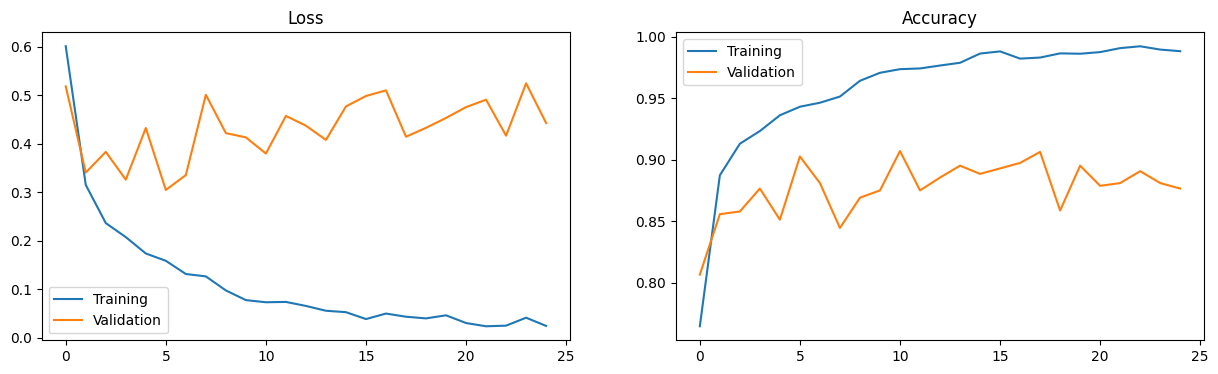

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Validation')
plt.legend()

In [ ]:
preds1, true1 = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), dim=1).detach().cpu()
        preds1.append(pred)
        true1.append(y)

print(len(preds1), len(true1))

100%|██████████| 14/14 [00:09<00:00,  1.52it/s]

14 14


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


422 422


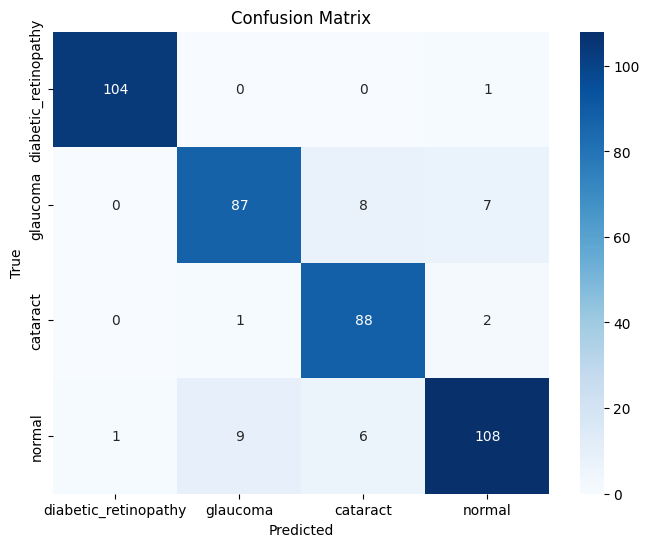

Precision: 0.9163
Recall: 0.9204
F1 Score: 0.9173


In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

preds1, true1 = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), dim=1).detach().cpu().numpy()
        preds1.extend(pred)
        true1.extend(y.numpy())

print(len(preds1), len(true1))

# Create id2label dictionary from label2id
id2label = {v: k for k, v in label2id.items()}

# Convert labels to one-hot encoded format
true1_onehot = label_binarize(true1, classes=list(label2id.values()))
preds1_onehot = label_binarize(preds1, classes=list(range(len(label2id))))

# Compute confusion matrix
cm = confusion_matrix(true1, preds1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Precision: {:.4f}".format(precision_score(true1_onehot, preds1_onehot, average='macro')))
print("Recall: {:.4f}".format(recall_score(true1_onehot, preds1_onehot, average='macro')))
print("F1 Score: {:.4f}".format(f1_score(true1_onehot, preds1_onehot, average='macro')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


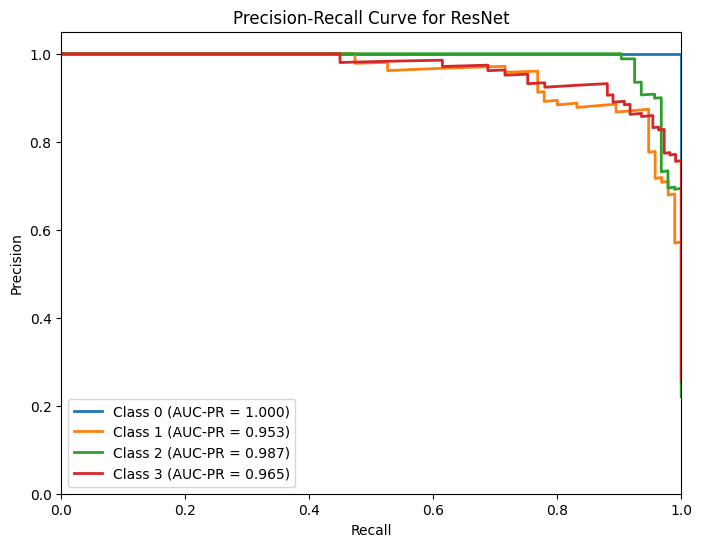

In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained ResNet model
model = Net()
model.load_state_dict(torch.load('trained_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Assuming you have test_loader for the test dataset
y_true = []
y_score = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Collect true labels and model scores/probabilities
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.softmax(dim=1).cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_score = np.array(y_score)

# Compute precision-recall curve and AUC-PR for each class
n_classes = y_score.shape[1]
precision, recall, thresholds = dict(), dict(), dict()
auc_pr = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_score[:, i])
    auc_pr.append(average_precision_score(y_true == i, y_score[:, i]))

# Plot the PR curve for each class
plt.figure(figsize=(8, 6))
lines = []
labels = []
for i in range(n_classes):
    line, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(line)
    labels.append(f'Class {i} (AUC-PR = {auc_pr[i]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for ResNet')
plt.legend(lines, labels, loc='best')
plt.show()

##VGG Model

In [ ]:
import torch.optim as optim

In [ ]:

num_classes = 4  # Number of classes (e.g., normal, cataract, diabetic retino, glaucoma)
# Define VGG model
class VGGModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGModel, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = VGGModel(num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define number of epochs
n_epochs = 25

# Training loop
for epoch in range(n_epochs):
    model.train()  # Set the model to train mode

    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        train_acc = (predicted == labels).sum().item() / labels.size(0)
        train_accs.append(train_acc)

    epoch_train_loss = sum(train_loss) / len(train_loss)
    epoch_train_acc = sum(train_accs) / len(train_accs)

    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'vgg_model.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.4MB/s]
100%|██████████| 106/106 [01:45<00:00,  1.00it/s]


Epoch [1/25], Train Loss: 0.7756, Train Accuracy: 0.6968


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [2/25], Train Loss: 0.4131, Train Accuracy: 0.8455


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [3/25], Train Loss: 0.2989, Train Accuracy: 0.8858


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [4/25], Train Loss: 0.2489, Train Accuracy: 0.9113


100%|██████████| 106/106 [01:43<00:00,  1.02it/s]


Epoch [5/25], Train Loss: 0.2281, Train Accuracy: 0.9142


100%|██████████| 106/106 [01:45<00:00,  1.01it/s]


Epoch [6/25], Train Loss: 0.2227, Train Accuracy: 0.9175


100%|██████████| 106/106 [01:45<00:00,  1.00it/s]


Epoch [7/25], Train Loss: 0.2016, Train Accuracy: 0.9270


100%|██████████| 106/106 [01:46<00:00,  1.00s/it]


Epoch [8/25], Train Loss: 0.1783, Train Accuracy: 0.9340


100%|██████████| 106/106 [01:45<00:00,  1.01it/s]


Epoch [9/25], Train Loss: 0.1698, Train Accuracy: 0.9353


100%|██████████| 106/106 [01:45<00:00,  1.01it/s]


Epoch [10/25], Train Loss: 0.1783, Train Accuracy: 0.9307


100%|██████████| 106/106 [01:44<00:00,  1.02it/s]


Epoch [11/25], Train Loss: 0.1540, Train Accuracy: 0.9428


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [12/25], Train Loss: 0.1421, Train Accuracy: 0.9443


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [13/25], Train Loss: 0.1309, Train Accuracy: 0.9505


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [14/25], Train Loss: 0.1306, Train Accuracy: 0.9499


100%|██████████| 106/106 [01:45<00:00,  1.00it/s]


Epoch [15/25], Train Loss: 0.1232, Train Accuracy: 0.9558


100%|██████████| 106/106 [01:44<00:00,  1.01it/s]


Epoch [16/25], Train Loss: 0.0981, Train Accuracy: 0.9627


100%|██████████| 106/106 [01:43<00:00,  1.02it/s]


Epoch [17/25], Train Loss: 0.1092, Train Accuracy: 0.9590


100%|██████████| 106/106 [01:43<00:00,  1.03it/s]


Epoch [18/25], Train Loss: 0.1099, Train Accuracy: 0.9584


100%|██████████| 106/106 [01:41<00:00,  1.04it/s]


Epoch [19/25], Train Loss: 0.0881, Train Accuracy: 0.9699


100%|██████████| 106/106 [01:43<00:00,  1.03it/s]


Epoch [20/25], Train Loss: 0.0886, Train Accuracy: 0.9677


100%|██████████| 106/106 [01:43<00:00,  1.02it/s]


Epoch [21/25], Train Loss: 0.0844, Train Accuracy: 0.9679


100%|██████████| 106/106 [01:42<00:00,  1.03it/s]


Epoch [22/25], Train Loss: 0.0950, Train Accuracy: 0.9643


100%|██████████| 106/106 [01:42<00:00,  1.03it/s]


Epoch [23/25], Train Loss: 0.0765, Train Accuracy: 0.9727


100%|██████████| 106/106 [01:46<00:00,  1.01s/it]


Epoch [24/25], Train Loss: 0.0669, Train Accuracy: 0.9758


100%|██████████| 106/106 [01:46<00:00,  1.01s/it]


Epoch [25/25], Train Loss: 0.0629, Train Accuracy: 0.9789


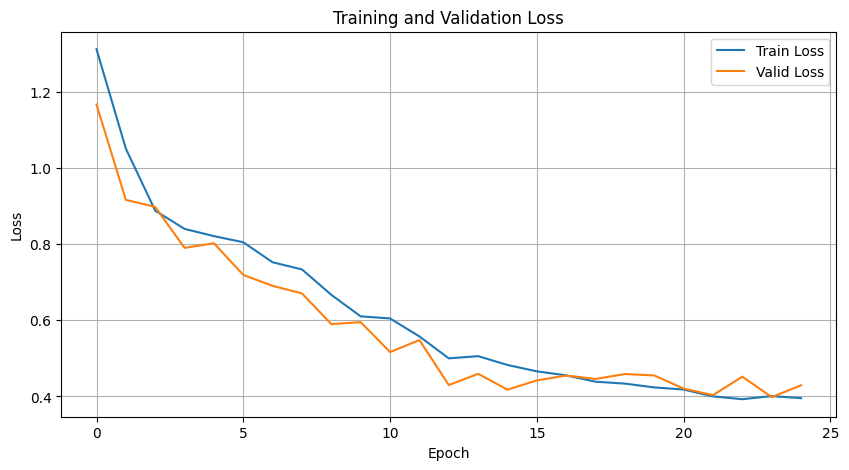

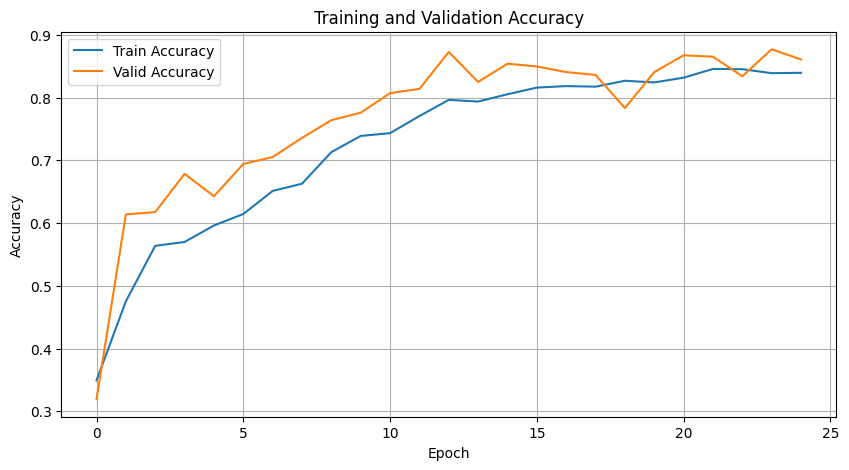

In [ ]:

# Plotting loss and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


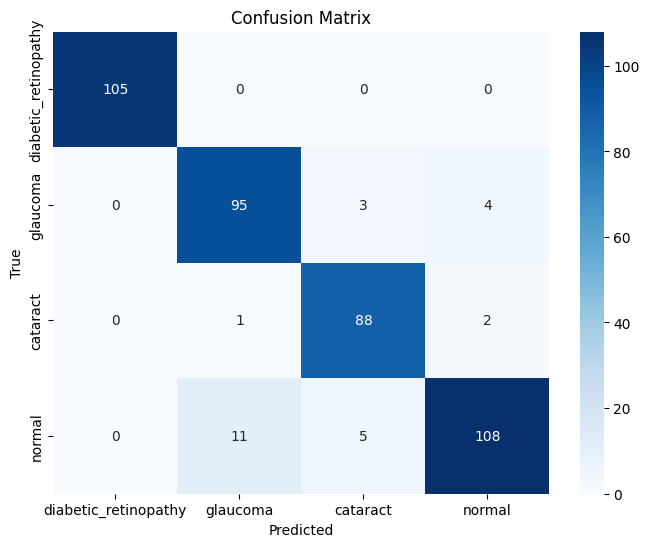

F1 Score: 0.9395
Precision: 0.9380
Recall: 0.9423


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = VGGModel(num_classes)
model.load_state_dict(torch.load('vgg_model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

preds, true_labels = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Convert labels to one-hot encoded format
true_labels_onehot = label_binarize(true_labels, classes=list(label2id.values()))
preds_onehot = label_binarize(preds, classes=list(range(len(label2id))))

# Calculate evaluation metrics
f1 = f1_score(true_labels_onehot, preds_onehot, average='macro')
precision = precision_score(true_labels_onehot, preds_onehot, average='macro')
recall = recall_score(true_labels_onehot, preds_onehot, average='macro')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

In [ ]:
import torch

# Load the trained model
model = VGGModel(num_classes)
model.load_state_dict(torch.load('vgg_model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

y_score = []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        x = x.to(device)
        outputs = model(x)
        y_score.extend(outputs.cpu().numpy())

y_true = [label for _, label in val_loader.dataset]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


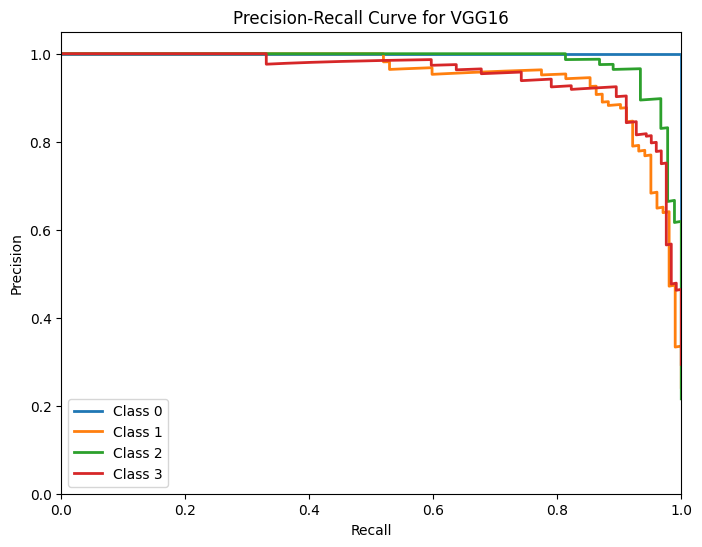

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true (true labels) and y_score (model scores or probabilities)
y_true = np.array(y_true)
y_score = np.array(y_score)

# Compute the precision-recall curve for each class
n_classes = len(np.unique(y_true))
precision, recall, thresholds = dict(), dict(), dict()

# Convert true labels to one-hot encoded format
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true_onehot[:, i], y_score[:, i])

# Plot the PR curve for each class
plt.figure(figsize=(8, 6))
lines = []
labels = []
for i in range(n_classes):
    line, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(line)
    labels.append(f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for VGG16')
plt.legend(lines, labels, loc='best')
plt.show()

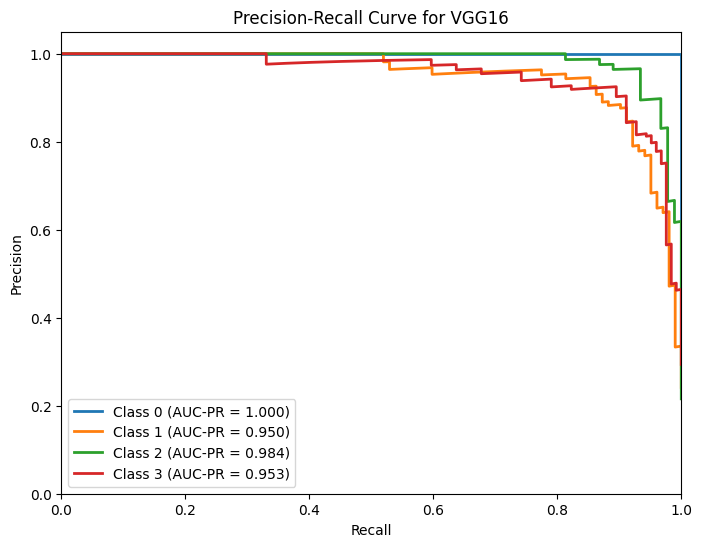

AUC-PR score for Class 0: 1.000
AUC-PR score for Class 1: 0.950
AUC-PR score for Class 2: 0.984
AUC-PR score for Class 3: 0.953


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true (true labels) and y_score (model scores or probabilities)
y_true = np.array(y_true)
y_score = np.array(y_score)

# Compute the precision-recall curve for each class
n_classes = len(np.unique(y_true))
precision, recall, thresholds = dict(), dict(), dict()
auc_pr_scores = dict()

# Convert true labels to one-hot encoded format
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true_onehot[:, i], y_score[:, i])
    auc_pr_scores[i] = average_precision_score(y_true_onehot[:, i], y_score[:, i])

# Plot the PR curve for each class
plt.figure(figsize=(8, 6))
lines = []
labels = []
for i in range(n_classes):
    line, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(line)
    labels.append(f'Class {i} (AUC-PR = {auc_pr_scores[i]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for VGG16')
plt.legend(lines, labels, loc='best')
plt.show()

# Print the AUC-PR scores for each class
for i in range(n_classes):
    print(f'AUC-PR score for Class {i}: {auc_pr_scores[i]:.3f}')
